This can be run [run on Google Colab using this link](https://colab.research.google.com/github/CS7150/CS7150-Homework_3/blob/main/HW3.2-Diffusion.ipynb)

# STABLE DIFFUSION ASSIGNMENT



## Preliminary

In this homework assignment, you will delve deep into Stable Diffusion Models based on the DDPMs paper. The homework is fragmented into three main parts: Forward Diffusion, the Unet Architecture of Noise Predictor Model with training and the Sampling part of Stable Diffusion Models. By completing this assignment, you will gain a comprehensive understanding of the mathematics underlying stable diffusion and practical skills to implement and work with these models.

### Setup and Data Preparation


Execute the provided cell to import essential libraries, ensure result reproducibility, set device configurations, download the MNIST dataset, and initialize DataLoaders for training, validation, and testing.

***Note: Run the cell as is; no modifications are necessary.***

In [1]:
############################################################################
#                                 TO DO                                    #
#               Execute the block to load & Split the Dataset              #
############################################################################

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F


# Ensure reproducibility
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download and Load the MNIST dataset
transform = transforms.ToTensor()
full_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Splitting the trainset into training and validation datasets
train_size = int(0.8 * len(full_trainset))  # 80% for training
val_size = len(full_trainset) - train_size  # remaining 20% for validation
train_dataset, val_dataset = torch.utils.data.random_split(full_trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)



100%|██████████| 9912422/9912422 [00:00<00:00, 128324849.21it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 71677925.34it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 48602149.02it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20137979.67it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Image Display Function



Below is a utility function, `display_images`, used for visualizing dataset and monitoring diffusion process for slight intuitive way of choosing parameter purposes and display results post training in this assignment.


***Note: Run the cell to view the images from the dataset.***

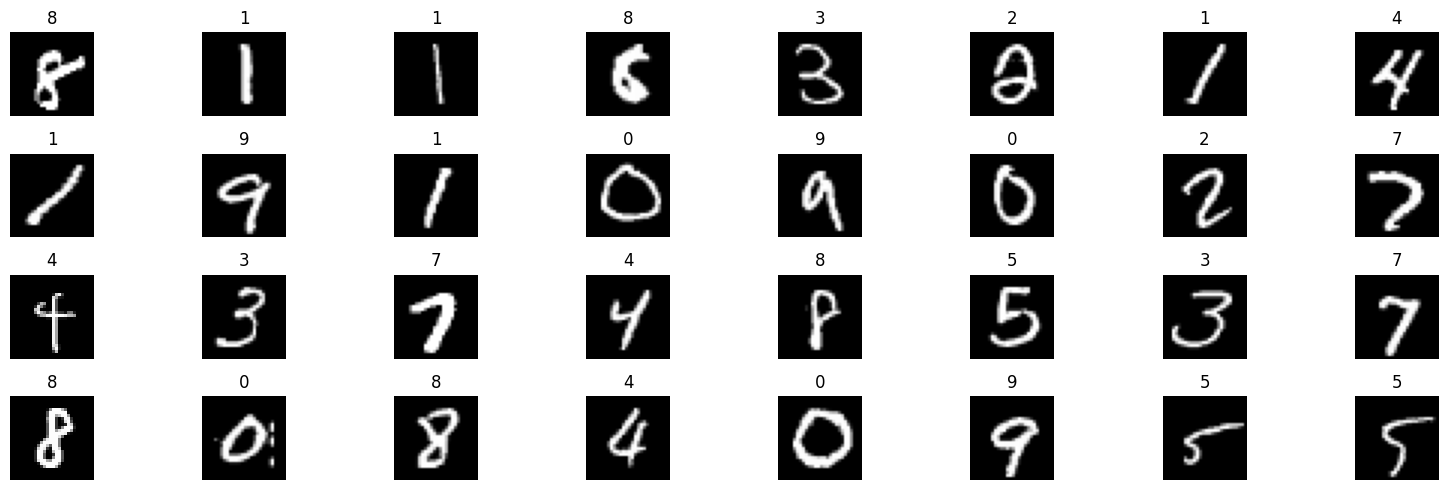

In [2]:
############################################################################
#                                 TO DO                                    #
#               Execute the block to display images of MNIST               #
############################################################################

import matplotlib.pyplot as plt

def display_images(images, n, images_per_row=5, labels = None):
    """
    Display n images in rows where each row contains a specified number of images.

    Parameters:
    - images: List/Tensor of images to display.
    - n: Number of images to display.
    - images_per_row: Number of images per row.
    """
    # Define the number of rows based on n and images_per_row
    num_rows = (n + images_per_row - 1) // images_per_row  # Rounding up
    plt.figure(figsize=(2*images_per_row, 1.25 * num_rows))
    for i in range(n):
        plt.subplot(num_rows, images_per_row, i+1)
        plt.imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
        if labels is not None:
          plt.title(labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


for batch in trainloader:
  # In a batch from many batches in trainloader, get the the first one and work with that
  batch_size = len(batch[0])
  display_images(images= batch[0],n = batch_size, images_per_row=8, labels = batch[1].tolist())
  break


## EXERCISE 1: FORWARD DIFFUSION

### Noise Diffusion


The following block `Noise Diffusion` is to give you a high level intuition of what forward diffusion process is and how we achieve results without any dependency on prior results. There is a detailed derivation on how we landed on the formula mentioned in the paper and below, if you're interested in the math, we recommend reading [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) for clear understanding of ***Forward Diffusion Process*** and mathematical details involved in it!


---



#### Noise Diffusion

The idea behind adding noise to an image is rooted in a simple linear interpolation between the original image and a noise term. Let's use the concept of a blending or mixing factor (which we'll refer to as $\alpha$)


##### ***1. Linear Interpolation:***

Given two values, $A$ and $B$, the linear interpolation between them based on a blending factor $\alpha$ (where $0 \leq \alpha \leq 1$) is given by:

  $$
  \text{Result} = \alpha A + (1 - \alpha) B \
  $$

If $\alpha = 1$, the Result is entirely $A$. If $\alpha = 0$, the Result is entirely $B$. For values in between, you get a mixture.

##### ***2. Applying to Images and Noise:***

In our context:
- $A$ is the original image.
- $B$ is the noise (often drawn from a standard normal distribution, but could be any other distribution or type of noise).

So, for each pixel \(p\) in our image, and at a given timestep \(t\):

  $$
  \text{noisy_image}_p(t) = \alpha(t) \times \text{original_image}_p + (1 - \alpha(t)) \times \text{noise}_p \
  $$

Where:
- $\alpha(t)$ is the blending factor at timestep $t$
- $\text{original_image}_p $ is the intensity of pixel $p$ in the original image.
- $\text{noise}_p $ is the noise value for pixel $p$, typically drawn from a normal distribution.

##### ***3. Time-Dependent***  \$\alpha$:

For the Time-Dependent Alpha Noise Diffusion method, our $\alpha$ isn't a constant; it changes over time. That's where our linear scheduler or any other scheduler comes in: to provide a sequence of values over timesteps.

Now, considering cumulative products: The reason for introducing the cumulative product of $\alpha$s was to have an accumulating influence of noise over time. With each timestep, we multiply the original image with the cumulative product of $\alpha$ values up to that timestep, making the original image's influence reduce multiplicatively. The noise's influence, conversely, grows because it's based on $1 -$ the cumulative product of the $\alpha$s.

That's why the formula becomes:

$$ \text{noisy_image}_t = \text{original_image} \times \prod_{i=1}^{t} \alpha_i + \text{noise} \times (1 - \prod_{i=1}^{t} \alpha_i) $$


In essence, this formula is just a dynamic way to blend an original image and noise, with the blending ratios changing (and typically becoming more skewed toward noise) over time.


##### ***4. Linear Scheduling of Noise Blending:***

One of the core components of this noise diffusion assignment is how the blending of noise into the original image is scheduled. To accomplish this, we utilize a linear scheduler that determines the progression of the $\beta$ (noise level parameter) over a series of timesteps.

Imagine you wish to transition $\beta$ from a `start_beta` of 0.1 to an `end_beta` of 0.2 over 11 timesteps. The goal is for the rate of noise blending into the image to increase progressively. In this case, the sequence of $\beta$ values would look like this: [0.1, 0.11, 0.12,..., 0.2].

This sequence, `self.betas`, is precisely what the `linear_scheduler` generates.
```python
self.betas = self.linear_scheduler().to(self.device)
```

In essence, the `linear_scheduler` method calculates the sequence of $\beta$ values for the diffusion process, ensuring that the noise blending into the image increases linearly over the given timesteps.


#### Terminologies:
1. $ \beta $: Represents the noise level parameter, defined between the start and end beta values.
2. $ \alpha $: Represents the blending factor, calculated as $( 1 - \beta )$.
3. Cumulative Product of $ \alpha $: Understand its significance in dynamically blending the original image and noise over timesteps, without any dependency on prior timesteps.

---

### NoiseDiffuser Class


***TO DO***

Implement `NoiseDiffuser` Class,  ***Follow Instructions in the code cell***







---

In [ ]:
import torch

class NoiseDiffuser:
  def __init__(self, start_beta, end_beta, total_steps, device='cpu'):

    assert start_beta < end_beta < 1.0

    self.device = device
    self.start_beta = start_beta
    self.end_beta = end_beta
    self.total_steps = total_steps
    ############################################################################
    #                                 TO DO                                    #
    #                  Compute the following variables needed                  #
    #                      for Forward Diffusion Process                       #
    #                  schedule betas,  compute alphas & cumulative            #
    #                              product of alphas                           #
    ############################################################################
    raise NotImplementedError
    self.betas = None
    self.alphas = None
    self.alpha_bar = None # Linear Cumulative Products of alphas!


  def linear_scheduler(self):
    """Returns a linear schedule from start to end over the specified total number of steps."""
    ############################################################################
    #                                 TO DO                                    #
    #                  Return a linear schedule of `betas`                     #
    #                    from `start_beta` to `end_beta`                       #
    #                         hint: torch.linspace()                           #
    ############################################################################
    raise NotImplementedError

  def noise_diffusion(self, image, t):
    """
    Diffuse noise into an image based on timestep t using the pre-computed cumulative product of alphas.
    """
    ############################################################################
    #                                 TO DO                                    #
    #                 Process the given `image` for timesteps `t`              #
    #                Return processed image & necessary variables              #
    ############################################################################
    image = image.to(self.device)

    raise NotImplementedError

    return


### Testing NoiseDiffuser Class (SANITY CHECK)

In [ ]:
# SANITY CHECK
in_channels_arg = 1
out_channels_arg = 1
batch_size = 32
height = 28
width = 28
total_timesteps = 50
start_beta, end_beta = 0.001, 0.2


# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sanity check
x = torch.randn((batch_size, in_channels_arg, height, width)).to(device)
diffuser = NoiseDiffuser(start_beta, end_beta, total_timesteps, device)



timesteps_to_display = torch.randint(0, total_timesteps, (batch_size,), device=device).long().tolist()
y, _ = diffuser.noise_diffusion(x, timesteps_to_display)

assert len(x.shape) == len(y.shape)
assert y.shape == x.shape

print("Sanity Check for shape mismatches")
print("Shape of the input : ", x.shape)
print("Shape of the output : ", y.shape)


Sanity Check for shape mismatches
Shape of the input :  torch.Size([32, 1, 28, 28])
Shape of the output :  torch.Size([32, 1, 28, 28])


### Demonstrating Examples



***Note: Observe the visual effect of noise diffusion for different images at random timesteps. How does the noise appear?***

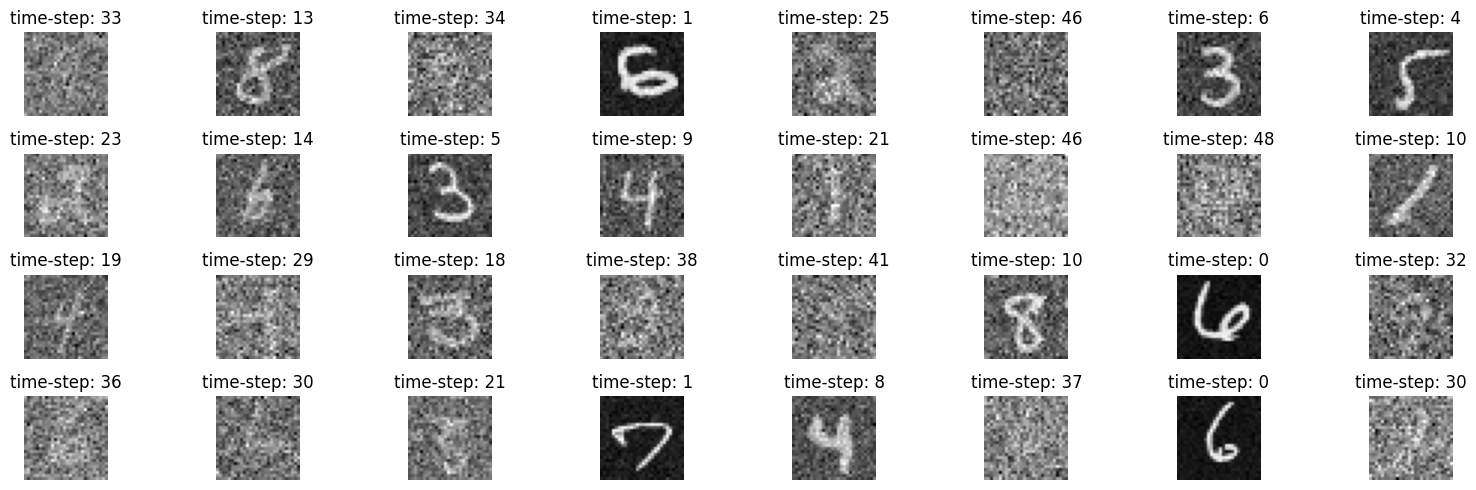

In [ ]:
############################################################################
#                                 TO DO                                    #
#       Initialize some start_beta, end_beta & total_timesteps             #
#                        and execute the block                             #
############################################################################
raise NotImplementedError

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
total_timesteps = None
start_beta, end_beta = None, None
diffuser = NoiseDiffuser(start_beta, end_beta, total_timesteps, device)

for batch in trainloader:
    minibatch = batch[0]
    batch_size = len(minibatch)
    timesteps_to_display = torch.randint(0, total_timesteps, (batch_size,), device=device).long().tolist()
    noisy_images,_ = diffuser.noise_diffusion(minibatch, timesteps_to_display)
    display_images(images=noisy_images, n=batch_size, images_per_row=8, labels=list(map(lambda x: "time-step: " + str(x), timesteps_to_display)))
    break



### HyperParameters

Smartly setting the start and end values of beta can control the noise diffusion's character.

- **Lower Start and Higher End**: Starting with a lower beta and ending with a higher one means that original image's contribution remains dominant in the beginning and slowly diminishes. This can be useful when the goal is to have a gradual transition from clear image to noisier version.
  
- **Higher Start and Lower End**: The opposite approach, starting with a Higher beta and ending with a lower one, can be useful when goal is to introduce noise more aggressively initially and taper off towards the end.

- **THINK WHAT WOULD WE NEED** `Higher Start and Lower End` or `Lower Start and Higher End`

The precise values can be fine-tuned based on specific requirements, visual assessments (like in the cell below) or even metrics.

**Exploration with Varied beta Values and Timesteps**:
   - In the below cell, you are encouraged to tweak values of `start_beta` and `end_beta` and even modify `total_timesteps` to observe the effect over a longer/shorter period
   
***Note: Pay close attention to how the noise diffusion evolves over time. Can you see a clear transition from the start to the end timestep? How do different images react to the same noise diffusion process?***

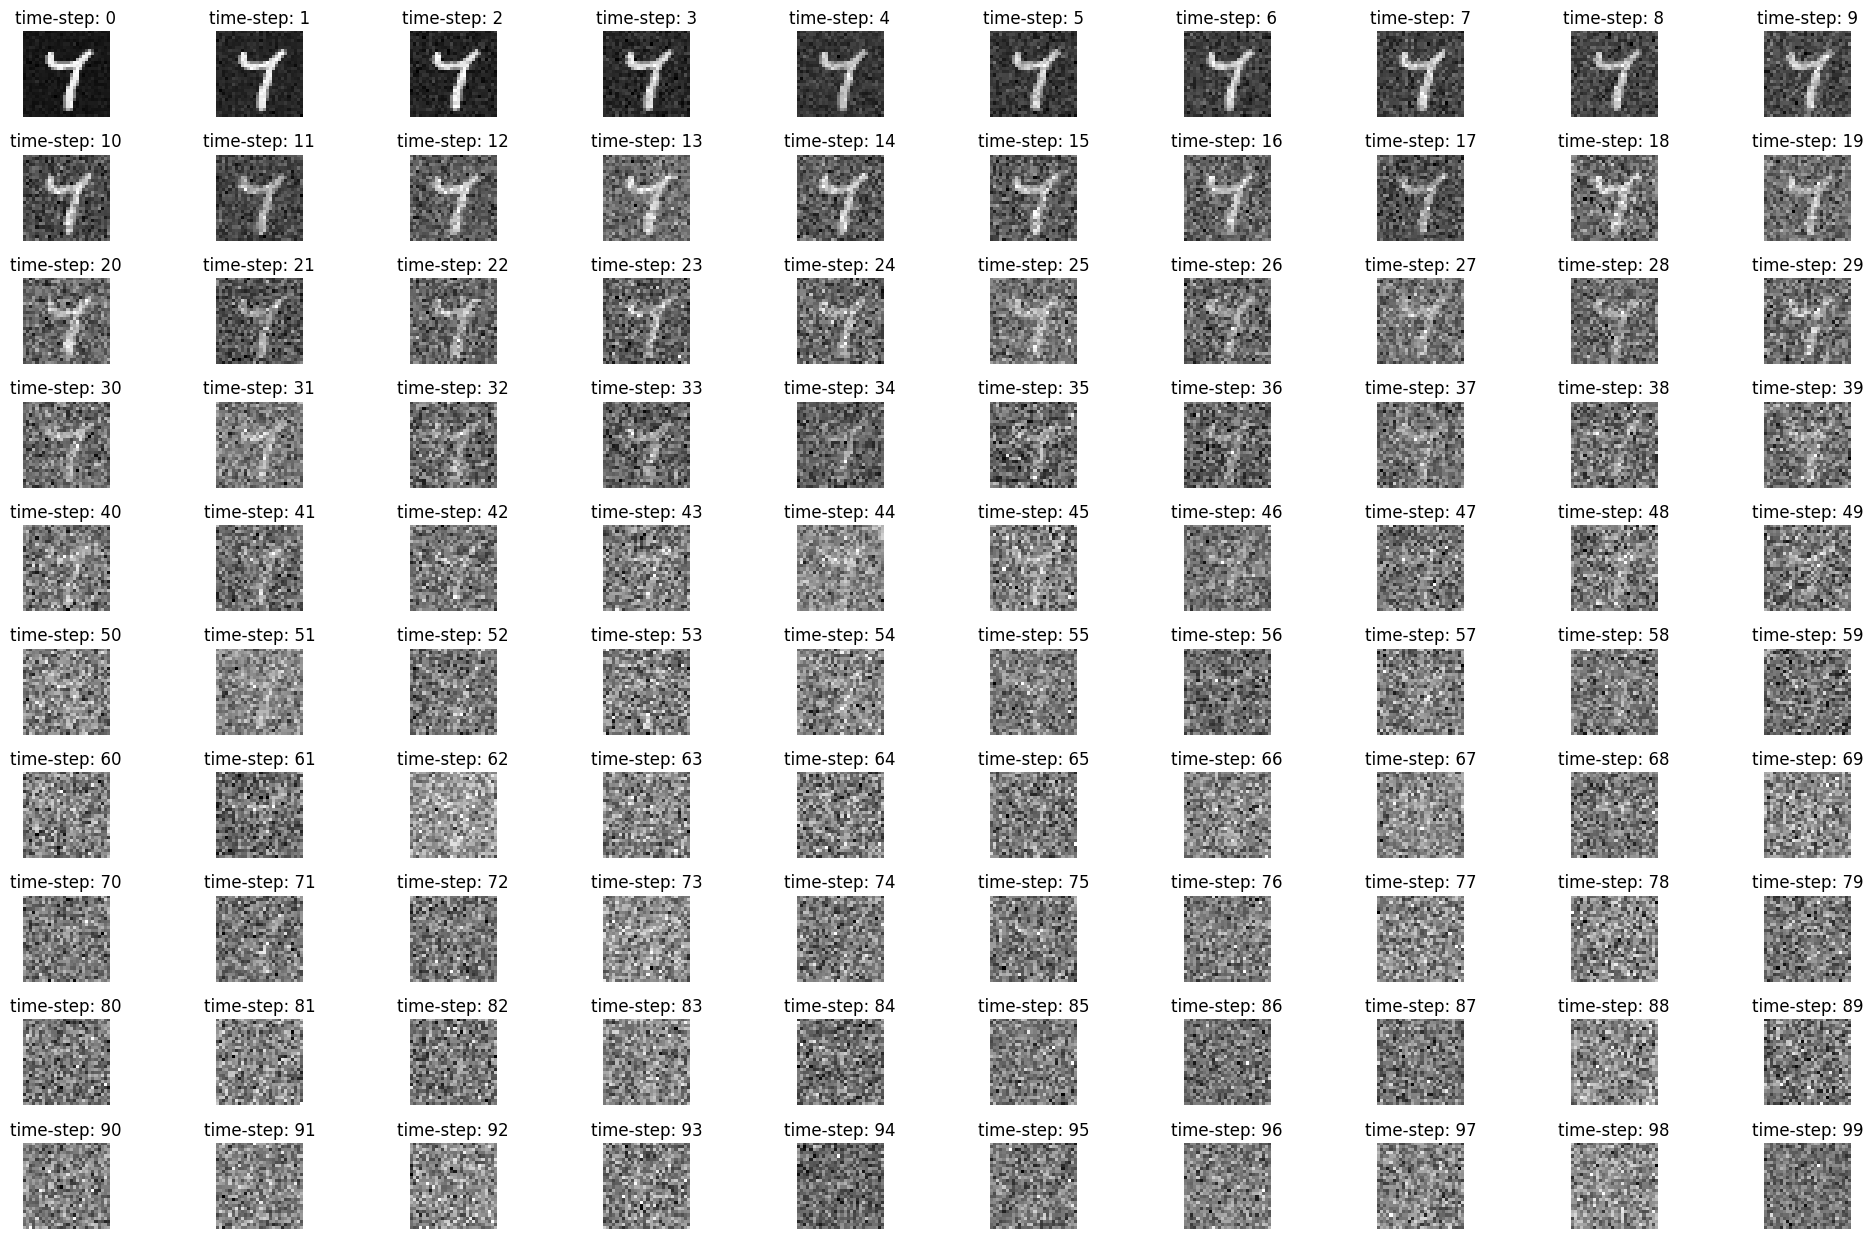

In [ ]:
############################################################################
#                                 TO DO                                    #
#       Initialize some start_beta, end_beta & total_timesteps             #
#         play around and see the effect of noise introduced               #
#         and think what parameters would you use for training             #
############################################################################
raise NotImplementedError

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
total_timesteps = None
start_beta, end_beta = None, None
minibatch_size = 1
diffuser = NoiseDiffuser(start_beta, end_beta, total_timesteps, device)

# PLay around in this cell with different value of alpha (start and end) and different number of time steps to initially guess and decide on how many time steps would you like to train the model going forward.
for batch in trainloader:
    repetitions = torch.tensor([total_timesteps]).repeat(minibatch_size)
    minibatch = batch[0][:minibatch_size,:,:].repeat_interleave(repetitions, dim=0)
    batch_size = len(minibatch)
    timesteps_to_display = torch.linspace(0, total_timesteps-1, total_timesteps, dtype=int).tolist() * minibatch_size
    noisy_images,_ = diffuser.noise_diffusion(minibatch, timesteps_to_display)
    display_images(images=noisy_images, n=batch_size, images_per_row=10, labels=list(map(lambda x: "time-step: " + str(x), timesteps_to_display)))
    break


## EXERCISE 2: REVERSE DIFFUSION

### Model Architecture

###### ***Implementing Skip Connections in U-Net Architecture***
While the architecture of the U-Net is provided to you, a critical component—skip connections—needs to be integrated by you. The original paper, "[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)" showcases the importance of these skip connections, as they allow the network to utilize features from earlier layers, making the segmentation more precise.




##### ***Placeholder for Skip Connections:***

In the given architecture, you will find lines like the one below, which are the components of upsampling process in the U-Net:

```python
y2 = self.afterup2(torch.cat([y2, torch.zeros_like(y2)], axis = 1))
```

Here, `torch.zeros_like(y2)` acts as a placeholder, indicating where the skip connection should be added. Your task is to replace this placeholder with the appropriate feature map from an earlier corresponding layer in the network.



---

##### Important Points to Keep in Mind:

- The U-Net architecture has multiple layers, so you'll need to repeat this process for each layer where skip connections are required.

- The provided helper function, `self.xLikeY(source, target)`, will be crucial in ensuring the feature maps you concatenate have matching dimensions.

- While the focus of this assignment is on crucial idea of stable diffusion, the U-Net architecture is provided to you but it is importatnt you implement skip connections, as understanding their role and significance in the U-Net architecture will be beneficial.

- ***Note: Feel free to modify architecture, parameters including number & types of layers used, kernel Sizes, padding, etc, you won't be judged on the architecture you use if you have the desired results post training.***


### UNet Class

***TO DO***

Fill in `UNet` Class,  ***Follow Instructions above***







---

In [3]:
class UNet(nn.Module):

    def __init__(self, in_channels, out_channels):
      """"
      in_channels: input channels of the incoming image
      out_channels: output channels of the incoming image
      """
      super(UNet, self).__init__()

      #------------------------ Encoder ------------------------#
      ############################################################################
      #        Initial Convolutions (Using doubleConvolution() function)         #
      #           Building Down Sampling Layers (Using Down() function)          #
      ############################################################################
      self.ini = self.doubleConvolution(inC = in_channels, oC = 16)
      self.down1 = self.Down(inputC = 16, outputC = 32)
      self.down2 = self.Down(inputC = 32, outputC = 64)

      #------------------------ Decoder ------------------------#
      ############################################################################
      #                        For each Upsampling block                         #
      #         Building Time Embeddings (Using timeEmbeddings() function)       #
      #       Building Up Sampling Layer (Using ConvTranspose2d() function)      #
      #       followed by Convolution (Using doubleConvolution() function)       #
      ############################################################################

      self.time_emb2 = self.timeEmbeddings(1, 64)
      self.up2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2)
      self.afterup2 = self.doubleConvolution(inC = 64 , oC = 32)

      self.time_emb1 = self.timeEmbeddings(1, 32)
      self.up1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2)
      self.afterup1 = self.doubleConvolution(inC = 32 , oC = 16, kS1=5, kS2=4)

      #------------------------ OUTPUT ------------------------#
      ############################################################################
      #            Constructing final Output Layer (Use Conv2d() function)       #
      ############################################################################
      self.out = nn.Conv2d(in_channels=16, out_channels=out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, t=None):
      assert t is not None

      #------------------------ Encoder ------------------------#
      ############################################################################
      #                           Processing Inputs by                           #
      #                      performing Initial Convolutions                     #
      #                       followed by Down Sampling Layers                   #
      ############################################################################
      x1 = self.ini(x)                  # Initial Double Convolution
      x2 = self.down1(x1)               # Downsampling followed by Double Convolution
      x3 = self.down2(x2)               # Downsampling followed by Double Convolution

      #------------------------ Decoder ------------------------#
      ############################################################################
      #            For each Upsampling block, we add time Embeddings to          #
      #                   Feature Maps, process this by                          #
      #            Up Sampling followed by concatenation & Convolution           #
      ############################################################################
      t2 = self.time_emb2(t)[:,:, None, None]
      y2 = self.up2(x3 + t2)                                                                    # Upsampling
      y2 = self.afterup2(torch.cat([y2, torch.zeros_like(y2)], axis = 1))                       # Crop corresponding Downsampled Feature Map, Double Convolution

      t1 = self.time_emb1(t)[:,:, None, None]
      y1 = self.up1(y2 + t1)                                                                    # Upsampling
      y1 = self.afterup1(torch.cat([y1, torch.zeros_like(y1)], axis = 1))                       # Crop corresponding Downsampled Feature Map, Double Convolution

      #------------------------ OUTPUT ------------------------#
      ############################################################################
      #                         Processing final Output                          #
      ############################################################################
      outY = self.out(y1)               # Output Layer (ks-1, st-1, pa-0)

      return outY



    #--------------------------------------------------------------------------------------------------- Helper Functions Within Model Class

    def timeEmbeddings(self, inC, oSize):
      """
      inC: Input Size, (for example 1 for timestep)
      oSize: Output Size, (Number of channels you would like to match while upsampling)
      """
      return nn.Sequential(nn.Linear(inC, oSize),
                            nn.ReLU(),
                            nn.Linear(oSize, oSize))

    def doubleConvolution(self, inC, oC, kS1=3, kS2=3, sT=1, pA=1):
      """
      Building Double Convolution as in original paper of Unet
      inC : inputChannels
      oC : outputChannels
      kS1 : Kernel_size of first convolution
      kS2 : Kernel_size of second convolution
      sT: stride
      pA: padding
      """
      return nn.Sequential(
            nn.Conv2d(in_channels= inC, out_channels=oC, kernel_size=kS1, stride=sT, padding=pA),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = oC,out_channels=oC, kernel_size=kS2, stride=sT, padding=pA),
            nn.ReLU(inplace=True),
      )


    def Down(self, inputC, outputC, dsKernelSize = None):
      """
      Building Down Sampling Part of the Unet Architecture (Using MaxPool) followed by double convolution
      inputC : inputChannels
      outputC : outputChannels
      """

      return nn.Sequential(
          nn.MaxPool2d(2),
          self.doubleConvolution(inC = inputC, oC = outputC)
      )


    def xLikeY(self, source, target):
      """
      Helper function to resize the downsampled x's to concatenate with upsampled y's as in Unet Paper
      source: tensor whose shape will be considered ---------UPSAMPLED TENSOR (y)
      target: tensor whose shape will be modified to align with target ---------DOWNSAMPLED TENSOR (x)
      """
      x1 = source
      x2 = target
      diffY = x2.size()[2] - x1.size()[2]
      diffX = x2.size()[3] - x1.size()[3]
      x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
      return x1


### Testing UNet Class (SANITY CHECK)


In [4]:
# SANITY CHECK FOR UnetBottleNeck (Single Channeled B/W Images)
in_channels_arg = 1
out_channels_arg = 1
batch_size = 32
height = 28
width = 28
total_timesteps = 50

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Positional Encoding Object
timesteps_to_display = torch.randint(0, total_timesteps, (batch_size,), device=device).long().tolist()

# Sanity check
x = torch.randn((batch_size, in_channels_arg, height, width)).to(device)
model = UNet(in_channels=in_channels_arg, out_channels=out_channels_arg)
model = model.to(device)

y = model.forward(x = x, t = torch.tensor(timesteps_to_display).to(torch.float32).cuda().view(-1,1))
assert len(x.shape) == len(y.shape)
assert y.shape == (batch_size, out_channels_arg, height, width)

print("Sanity Check for Single Channel B/W Images")
print("Shape of the input : ", x.shape)
print("Shape of the output : ", y.shape)


Sanity Check for Single Channel B/W Images
Shape of the input :  torch.Size([32, 1, 28, 28])
Shape of the output :  torch.Size([32, 1, 28, 28])


In [5]:

# SANITY CHECK FOR UnetBottleNeck (Colored Images)
in_channels_arg = 3
out_channels_arg = 1
batch_size = 32
height = 28
width = 28

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Positional Encoding Object
timesteps_to_display = torch.randint(0, total_timesteps, (batch_size,), device=device).long().tolist()

# Sanity check
x = torch.randn((batch_size, in_channels_arg, height, width)).to(device)
model = UNet(in_channels=in_channels_arg, out_channels=out_channels_arg)
model = model.to(device)

y = model.forward(x=x, t = torch.tensor(timesteps_to_display).to(torch.float32).cuda().view(-1,1))
assert len(x.shape) == len(y.shape)
assert y.shape == (batch_size, out_channels_arg, height, width)

print("Sanity Check for Multi-channel or colored Images")
print("Shape of the input : ", x.shape)
print("Shape of the output : ", y.shape)


Sanity Check for Multi-channel or colored Images
Shape of the input :  torch.Size([32, 3, 28, 28])
Shape of the output :  torch.Size([32, 1, 28, 28])


In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"The model has {num_params:,} trainable parameters.")


The model has 145,233 trainable parameters.


### Train the Model

 ###### In the following block, the train function is defined. You have to calculate the noisy data, feed forward through the model and pass the predicted noise and true noise to the criterion to calculate the loss.

In [7]:
from tqdm import tqdm

def train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs, diffuser, totalTrainingTimesteps):
    """
    model: Object of Unet Model to train
    train_loader: Training batches of the total data
    val_loader: Validation batches of the total data
    optimizer: The backpropagation technique
    criterion: Loas Function
    device: CPU or GPU
    num_epochs: total number of training loops
    diffuser: NoiseDiffusion class object to perform Forward diffusion
    totalTrainingTimesteps: Total number of forward diffusion timesteps the model is to be trained on
    """

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        # Wrapping your loader with tqdm to display progress bar
        train_progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for batch_idx, (data, _) in train_progress_bar:
            data = data.to(device)
            optimizer.zero_grad()

            # Use a random time step for training
            batch_size = len(data)
            timesteps = torch.randint(0, totalTrainingTimesteps, (batch_size,), device=device).long().tolist()


            ############################################################################
            #                                 TO DO                                    #
            #                     Calculate Noisy data, True noise                     #
            #                 and Predicted Noise, & then feed it to criterion         #
            ############################################################################
            raise NotImplementedError
            noisy_data, true_noise = None,None
            predicted_noise = None


            loss = criterion(predicted_noise, true_noise)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            train_progress_bar.set_postfix({'Train Loss': f'{loss.item():.4f}'})

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0

        # Wrapping your validation loader with tqdm to display progress bar
        val_progress_bar = tqdm(enumerate(val_loader), total=len(val_loader), desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for batch_idx, (data, _) in val_progress_bar:
                data = data.to(device)

                # For simplicity, we can use the same random timestep for validation
                batch_size = len(data)
                timesteps = torch.randint(0, totalTrainingTimesteps, (batch_size,), device=device).long().tolist()

                ############################################################################
                #                                 TO DO                                    #
                #                     Calculate Noisy data, True noise                     #
                #                 and Predicted Noise, & then feed it to criterion         #
                ############################################################################
                raise NotImplementedError
                noisy_data, true_noise = None,None
                predicted_noise = None

                loss = criterion(predicted_noise, true_noise)
                total_val_loss += loss.item()
                val_progress_bar.set_postfix({'Val Loss': f'{loss.item():.4f}'})

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses



###### In the following code block, initialize the necessary variables and then Execute to train, save model and plot the loss





Just to give you an idea of how loss curve would look like approximately (not necssarily same for everybody), x-axis represents epochs and y-axis represents loss.

<div align="center">
  <img src="https://drive.google.com/uc?export=view&id=14crtDhSbnaBNIgEBeG1toBAlpChoxbvV" width="500">
</div>

In [ ]:
############################################################################
#                                 TO DO                                    #
#                       Initialize the Constants below                     #
############################################################################
"""
- `total_time_steps`: Total time steps of forward diffusion
- `start_beta`: Initial point of Noise Level Parameter
- `end_beta`: End point of Noise Level Parameter
- `inputChannels`: 1 for Grayscale Images (Since we're Using MNIST)
- `outputChannels`: How many channels of predicted noise are aiming for? THINK!
- `num_epochs`: How many epochs are you training for? (*We'd love to see best results in minimum epcohs of training*)
"""
raise NotImplementedError
total_timesteps = None
startBeta, endBeta = None, None
inputChannels, outputChannels = None, None
num_epochs = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

############################################################################
#                                 TO DO                                    #
#                           Initialize the Model                           #
#                         Initialize the Optimizer                         #
#                      Initialize the Loss Function                        #
#                       Initialize the NoiseDiffuser                       #
############################################################################
raise NotImplementedError
stableDiffusionModel = None
optimizer = None
criterion = None
diffuser = None

############################################################################
#                                 TO DO                                    #
#                Execute this Block, Train & Save the Model                #
#                            And Plot the Progress                         #
############################################################################
stableDiffusionModel = stableDiffusionModel.to(device)
train_losses, val_losses = train(model= stableDiffusionModel,
                                 train_loader= trainloader,
                                 val_loader= valloader,
                                 optimizer= optimizer,
                                 criterion= criterion,
                                 device= device,
                                 num_epochs= num_epochs,
                                 diffuser= diffuser,
                                 totalTrainingTimesteps=total_timesteps)

# Save the model
torch.save(stableDiffusionModel.state_dict(), 'HW3SDModel.pth')

#Plot the losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## EXERCISE 3 : SAMLING GENERATION


### Sampling formula


The Stable Diffusion Model sampling code involves generating images from a trained model by iteratively denoising an initial random noise tensor. This process is executed in the reverse manner as compared to the diffusion process, where the noise is incrementally added. The iteration happens for a defined number of timesteps. The goal is to move from a purely noisy state to a clear, denoised state that represents a valid sample from the data distribution learned by the model. Refer to the DDPMs Paper for detailed documentation. The formula for sampling part is as follows:

$$
  X_{t-1} = \dfrac{1}{\sqrt \alpha} * \left( X_{t} - \frac{1-\alpha}{\sqrt  {\left( 1-\bar\alpha \right)} } * ϵ_t  \right) + \sqrt{β} * z  
$$



### Sample Images

Some sample outputs for random seeds as specified in the code cell of sampling generation and mentioned in the image below are as follows:

<div align="center">
  <img src="https://drive.google.com/uc?export=view&id=1_pGs1qJe3e1_dekcj3UuqjCJQORkzdzi" width="750">
</div>


In [ ]:
def generate_samples(x_t, model, num_samples, total_timesteps, diffuser, device):
    """
    Generate samples using the trained DDPM model.

    Parameters:
    - model: Trained UNetBottleneck model.
    - num_samples: Number of samples to generate.
    - total_timesteps: Total timesteps for the noise process.
    - diffuser: Instance of NoiseDiffuser.
    - device: Computing device (e.g., "cuda" or "cpu").

    Returns:
    - generated_samples: A tensor containing the generated samples.
    """



    # Varibales required by Sampling Formula
    one_by_sqrt_alpha = 1 / torch.sqrt(diffuser.alphas)
    beta_by_sqrt_one_minus_alpha_cumprod = diffuser.betas / torch.sqrt(1 - diffuser.alpha_bar)

    ############################################################################
    #                                 TO DO                                    #
    #                Implement the Sampling Algorithm, start with              #
    #                   pure noise, using the trained model                    #
    #                 perform denoising to generate MNIST Images               #
    ############################################################################
    # Iterate in reverse order to "denoise" the samples
    for timestep in range(total_timesteps-1, -1, -1):
      z = torch.randn_like(x_t)
      epsilon_t = None
      x_t_minus_1 = None
      x_t = None

    return x_t.detach()




############################################################################
#                                 TO DO                                    #
#                Post Implementation of Sampling Algorithm,                #
#                       Execute the following lines by                     #
#           using the same constants (timesteps and beta values)           #
#                         as you used while training,                      #
#                initializing instance of NoiseDiffuser Object             #
#                     and Loading the pretrained model                     #
############################################################################
# Create instance of NoiseDiffuser
diffuser = NoiseDiffuser(start_beta=startBeta, end_beta=endBeta, total_steps=total_timesteps, device= device)
# Using the function:
model_path = 'HW3SDModel.pth'
model = UNet(in_channels=inputChannels, out_channels=outputChannels).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()



SEED = [ 96, 786, 7150]  # You can set any integer value for the seed

for S in SEED:
  print("The Outputs for Random Seed {%d}"%S)
  # Set seed for both CPU and CUDA devices
  torch.manual_seed(S)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(S)
      torch.cuda.manual_seed_all(S)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False

  num_samples_to_generate = 10
  # Initialize with random noise
  xt = torch.randn((num_samples_to_generate, 1, 28, 28), device=device)


  samples = generate_samples(xt, model, num_samples_to_generate, total_timesteps, diffuser, device)

  # Display the generated samples
  display_images(samples, num_samples_to_generate, images_per_row=5)
